# Model Optimisation Testing

In [28]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
import graphviz 
import os 

# To Create a Report from: 
from docx import Document
from docx.shared import Inches

import sys
sys.path.append('/Users/krish/Desktop/DYNAMIC MODEL VEGETATION PROJECT/au_dyanamic_vegetation_project/STEP9_DATA_MODELLING_AND_EXPLORATION')

from sklearn.ensemble import RandomForestRegressor
import random
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from PreprocessData import * # import from custom transformers
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance
from skopt import BayesSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import ParameterGrid

import alibi
from alibi.explainers import ALE, plot_ale

from timeit import default_timer as timer

In [29]:
def plotPredictions(actual, prediction, TARGET, directory_plot_output, msg = '', split = '', fire_split = ''):
    fig, ax = plt.subplots(nrows = 3, figsize = (15,10))
    fig.suptitle(msg, fontsize=30)
    for i,v in enumerate(TARGET):
        actual[v].plot(ax=ax[i], color = 'blue', alpha = 0.4, linestyle='dashed', label = f'Observed {v.split("_")[0]}')
        prediction[f'prediction_{v}'].plot(ax=ax[i], color = 'orange', ylim = (0,100), label = f'Modelled {v.split("_")[0]}')
        ax[i].legend()
        ax[i].grid(True)
        if split:
            for s in split:
                ax[i].axvline(s, color='black', ls='--')
        if fire_split:
            for f in fire_split:
                ax[i].axvline(f, color='red', ls='--')
                
    plt.savefig(fname = directory_plot_output)
    plt.close()

In [30]:
# sites_list = np.unique(['TCATCH0004', 'TCATNM0001', 'TCATNM0003', 'TCATCH0006'])

#smaller_subset = pd.read_csv('../DATASETS/Sites_Subset_20231010/ausplots_site_info/sites_subset.csv').copy()
#bigger_subset = pd.read_csv('../DATASETS/Sites_Bigger_Subset_20240124/ausplots_bigger_subset.csv').copy()
#smaller_list = np.unique(list(np.unique(smaller_subset.site_location_name.values)))

super_group_list = ['Desert Chenopod', 'Desert Forb', 'Desert Hummock.grass',
       'Desert Shrub', 'Desert Tree.Palm', 'Desert Tussock.grass',
       'Temp/Med Shrub', 'Temp/Med Tree.Palm', 'Temp/Med Tussock.grass',
       'Tropical/Savanna Tree.Palm', 'Tropical/Savanna Tussock.grass']
selected_super_group = 'Desert Tree.Palm'
super_groups_classified = pd.read_csv('C:/Users/krish/Desktop/DYNAMIC MODEL VEGETATION PROJECT/au_dyanamic_vegetation_project/DATASETS/AusPlots_Extracted_Data/Final/sites_super_classified.csv')
selected_super_group_list = super_groups_classified.loc[super_groups_classified['super_group'] == selected_super_group]['site_location_name']

sites_list = selected_super_group_list
results_dir = f'C:/Users/krish/Desktop/DYNAMIC MODEL VEGETATION PROJECT/au_dyanamic_vegetation_project/RESULTS/Random_Forest_Results_On_Super_Group_Results/{selected_super_group}'

In [31]:
SEASONAL_FEATURES = ['photoperiod', 'photoperiod_gradient']

PRECIP_FEATURES = ['precip_30', 'precip_90', 'precip_180', 
                   'precip_365', 'precip_730', 'precip_1095', 
                   'precip_1460', 'MAP']

TEMP_FEATURES = ['tmax_lag', 'tmax_7', 'tmax_14', 
                 'tmax_30', 'tmin_lag', 'tmin_7', 
                 'tmin_14', 'tmin_30', 'MAT']

VPD_FEATURES = ['VPD_lag','VPD_7', 'VPD_14',
                'VPD_30']

LAG_FEATURES = ['pv_lag', 'npv_lag', 'bs_lag']

LAGGED_CHANGE_FEATURES = ['pv_change', 'npv_change', 'bs_change']

FIRE_FEATURES = ['days_since_fire', 'fire_severity']

CO2_FEATURES = ['CO2']

VEGETATION_FEATURES = ['grass', 'shrub', 'tree']

SOIL_FEATURES = ['SLGA_1','SLGA_2','SLGA_3', 'DER_000_999'] # the soil attributes to include

FEATURES =  SEASONAL_FEATURES + PRECIP_FEATURES + TEMP_FEATURES + VPD_FEATURES + FIRE_FEATURES + CO2_FEATURES + VEGETATION_FEATURES + SOIL_FEATURES # final features 
# Some testing

TARGET = ['pv_filter', 'npv_filter', 'bs_filter']
scores = []

In [32]:

# Training and test set 
datasets =  {} # entire set - for final evaluation 
training_set = {} # training set 
test_set = {} # test set 

# Iterate through the site list 

# Set up a random seed, based on the date it was set YYYYMMDD
random.seed(20240514)
number_of_blocks = 10
choices = [b for b in range(number_of_blocks)]
number_of_choices = len(sites_list)/len(choices)
duplicator = [round(np.floor(number_of_choices)) for i in range(len(choices))]

already_chosen = []
while sum(duplicator) != len(sites_list): # if there is an uneven split, keep adding 1 more until it sums to the avaliable number of datasets 
    chosen_index = random.randrange(0,len(duplicator),1)
    if chosen_index not in already_chosen:
        duplicator[chosen_index] += 1
        already_chosen.append(chosen_index)
    
random.shuffle(duplicator) # In cases where there is an uneven split, randomise which block gets the extra choice 
print(duplicator)

choice_adj = []
for index ,i in enumerate(choices):
    for j in range(duplicator[index]):
        choice_adj.append(i)
        
random.shuffle(choice_adj)
print(choice_adj)

# Now Construct the training and test dataset 
to_print_as_word = []

for i, site_location_name in enumerate(sites_list):
    site_merged = pd.read_csv(f'../DATASETS/DEA_FC_PROCESSED/MODELLED_PREPROCESSED/Input_DataSet_{site_location_name}.csv',
                              parse_dates = ['time']).copy().dropna(subset = FEATURES) # read and drop na
    site_merged.sort_values('time', inplace = True)
    site_merged.reset_index(inplace = True)
    
    period = len(site_merged)//number_of_blocks # get size of time period (as expressed by the number of data points)
    lower_bound = choice_adj[i] * period
    if lower_bound == choices[-1] * period: # if its the last block%, simply take all time points from there up to the most recent time point
        upper_bound = len(site_merged) -1
    else:
        upper_bound = lower_bound + period 

    # get test set 
    test = site_merged[(site_merged.index >= lower_bound) & (site_merged.index <= upper_bound)]
    word_text = f'{site_location_name} Test Set: {(site_merged.time[lower_bound], site_merged.time[upper_bound])}, Period: {period}'
    print(word_text)
    to_print_as_word.append(word_text)
    # get train set (note the selection condition is logically opposite to selection condition of the test set )
    train = site_merged[(site_merged.index < lower_bound) | (site_merged.index > upper_bound)]
    
    datasets[site_location_name] = site_merged
    training_set[site_location_name] = train
    test_set[site_location_name] = test
    
training_merged = pd.concat(training_set).dropna(subset = FEATURES) # drop na based on chosen features, needed for random forest 
training_merged.sort_values('time', inplace = True)
training_merged.set_index('time', inplace = True)

test_merged = pd.concat(test_set).dropna(subset = FEATURES)
test_merged.sort_values('time', inplace = True)
test_merged.set_index('time', inplace = True)

[7, 8, 7, 7, 7, 8, 8, 7, 7, 7]
[2, 6, 4, 6, 7, 8, 0, 4, 5, 1, 3, 5, 5, 6, 6, 1, 8, 8, 5, 7, 8, 8, 9, 1, 0, 7, 3, 2, 9, 6, 6, 2, 1, 5, 9, 1, 6, 4, 1, 3, 0, 2, 2, 3, 2, 0, 4, 4, 7, 3, 5, 1, 7, 4, 4, 9, 0, 8, 7, 0, 7, 9, 2, 5, 8, 9, 3, 3, 5, 0, 1, 6, 9]
NSABHC0028 Test Set: (Timestamp('1998-06-23 00:00:00'), Timestamp('2003-07-07 00:00:00')), Period: 86
NSABHC0029 Test Set: (Timestamp('2011-10-01 00:00:00'), Timestamp('2015-02-22 00:00:00')), Period: 86
NSACHC0002 Test Set: (Timestamp('2006-02-13 00:00:00'), Timestamp('2009-03-01 00:00:00')), Period: 89
NSACHC0003 Test Set: (Timestamp('2012-07-07 00:00:00'), Timestamp('2015-04-27 00:00:00')), Period: 89
NSACOP0001 Test Set: (Timestamp('2015-03-05 00:00:00'), Timestamp('2017-09-26 00:00:00')), Period: 81
NSACOP0002 Test Set: (Timestamp('2017-07-24 00:00:00'), Timestamp('2019-12-05 00:00:00')), Period: 79
NSAMDD0002 Test Set: (Timestamp('1987-09-21 00:00:00'), Timestamp('1993-04-14 00:00:00')), Period: 78
NSAMDD0005 Test Set: (Timestamp('20

In [6]:
random_state = 20240228
main_scorer = 'neg_mean_squared_error'
# Possible scorers:
    #  neg_mean_absolute_percentage_error'
    #  mean_squared_log_error
    # See more below:
    # https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics
    
## Test with Default RF 

criterion = ['squared_error', 'friedman_mse', 'poisson']
# Skip absolute error, as that is no optimised well 
max_depth = range(1, 56, 5)
oob_scores = []


param_grid = ParameterGrid({
    #'max_depth' : range(20, 55, 5),
    'min_samples_split': range(2, 20, 2),
    'criterion' : ['squared_error', 'friedman_mse', 'poisson']
})

start = timer()
for i, params in enumerate(param_grid): 
    print(f'Using params {params}, {i+1}/{len(list(param_grid))}')
    reg = RandomForestRegressor(**params, random_state = random_state, n_jobs = 8, oob_score= True)
    reg.fit(X = training_merged[FEATURES], y = training_merged[TARGET])
    oob_scores.append(reg.oob_score_)
end = timer()

print(f'Time taken: {end - start}')

Using params {'criterion': 'squared_error', 'min_samples_split': 2}, 1/27



KeyboardInterrupt



In [ ]:
plt.plot(range(2, 20, 2), oob_scores[:9])
plt.plot(range(2, 20, 2), oob_scores[9:18])
plt.plot(range(2, 20, 2), oob_scores[18:])
plt.legend(['MSE','Friedman_MSE', 'Possion']) 

In [ ]:
plt.plot(range(20, 55, 5), oob_scores[:7])
plt.plot(range(20, 55, 5), oob_scores[14:])
plt.legend(['MSE','Possion']) 

In [ ]:
param_grid[np.argmax(oob_scores)]

In [ ]:
random_state = 20240228
reg = RandomForestRegressor(random_state = random_state, n_jobs = 8, n_estimators = 100)
from sklearn.model_selection import ShuffleSplit
#ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

#reg.fit(X = training_merged[FEATURES], y = training_merged[TARGET])
train_scores = []
test_scores = []
sizes = np.linspace(0.1, 1.0, 5)

start = timer()
for i in sizes:
    print(f'Now Trying {i}th of the dataset size')
    number_of_samples = len(training_merged[FEATURES])
    random_index = random.sample(range(number_of_samples), int(number_of_samples*i))
    X = training_merged[FEATURES].iloc[random_index]
    y = training_merged[TARGET].iloc[random_index]
    rs = ShuffleSplit(n_splits=5, test_size= 0.2 , random_state=0)
    default_RF_CV = pd.DataFrame(cross_validate(reg, X = np.array(X),
                                                y = np.array(y), cv=rs,
                                                scoring='neg_mean_square_error',
                                                return_train_score = True))
    
    train_scores.append(default_RF_CV["train_score"].mean())
    test_scores.append(default_RF_CV["test_score"].mean())

end = timer()
print(f'Time taken: {end - start}')

Now Trying 0.1th of the dataset size
Now Trying 0.325th of the dataset size
Now Trying 0.55th of the dataset size
Now Trying 0.775th of the dataset size
Now Trying 1.0th of the dataset size
Time taken: 208.37128590000793


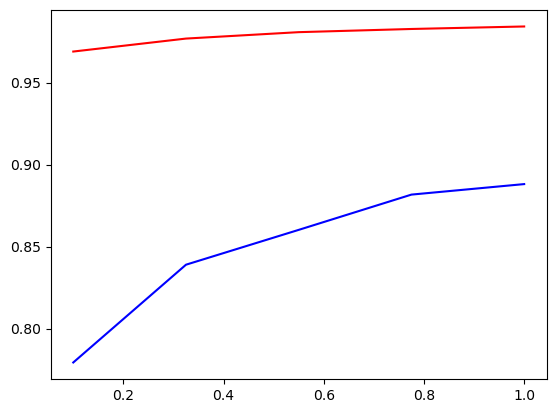

In [ ]:
plt.plot(sizes, np.abs(train_scores), color = 'red')
plt.plot(sizes, np.abs(test_scores), 'blue')

In [6]:
random_state = 20240228
reg = RandomForestRegressor(random_state = random_state, n_jobs = 8, n_estimators = 100)
reg.fit(training_merged[FEATURES], training_merged[TARGET])

print(mean_squared_error(reg.predict(training_merged[FEATURES]), training_merged[TARGET]))
print(mean_squared_error(reg.predict(training_merged[FEATURES]), training_merged[TARGET], multioutput = 'raw_values'))
print(mean_squared_error(reg.predict(test_merged[FEATURES]), test_merged[TARGET]))
print(mean_squared_error(reg.predict(test_merged[FEATURES]), test_merged[TARGET], multioutput = 'raw_values'))

1.0058911986091257
[0.91189849 0.90401096 1.20176415]
26.623375369444744
[20.80081099 23.75855447 35.31076065]


In [33]:
training_row = mean_squared_error(reg.predict(training_merged[FEATURES]), training_merged[TARGET], multioutput = 'raw_values')
testing_row = mean_squared_error(reg.predict(test_merged[FEATURES]), test_merged[TARGET], multioutput = 'raw_values')
training_mean = mean_squared_error(reg.predict(training_merged[FEATURES]), training_merged[TARGET])
testing_mean = mean_squared_error(reg.predict(test_merged[FEATURES]), test_merged[TARGET])
results_table = pd.DataFrame([training_row, testing_row], columns = TARGET)
results_table['loss_mean'] = [training_mean, testing_mean]
results_table['training_set'] = ['Train', 'Test']
results_table.set_index('training_set', inplace = True)

In [34]:
results_table

,pv_filter,npv_filter,bs_filter,loss_mean
training_set,,,,
Train,0.911898,0.904011,1.201764,1.005891
Test,20.800811,23.758554,35.310761,26.623375


In [35]:
results_table.shape

(2, 4)

In [24]:
from sklearn.neural_network import MLPRegressor

random_state = 20240228
reg = MLPRegressor(random_state = random_state, early_stopping = True, hidden_layer_sizes = [100, 100, 100, 100], )
reg.fit(training_merged[FEATURES], training_merged[TARGET])

print(mean_squared_error(reg.predict(training_merged[FEATURES]), training_merged[TARGET]))
print(mean_squared_error(reg.predict(training_merged[FEATURES]), training_merged[TARGET], multioutput = 'raw_values'))
print(mean_squared_error(reg.predict(test_merged[FEATURES]), test_merged[TARGET]))
print(mean_squared_error(reg.predict(test_merged[FEATURES]), test_merged[TARGET], multioutput = 'raw_values'))

43.51209832063631
[34.8194655  41.81911622 53.89771324]
53.66458779454417
[35.43155053 51.65919067 73.90302219]


In [36]:
historical_fire_ds = pd.read_csv('../DATASETS/AusPlotsBurnData/Combined_Data/AusPlots_Combined_Fire_Dataset.csv', parse_dates = ['ignition_d']) # Fire Dataset
results_dir = f'C:/Users/krish/Desktop/DYNAMIC MODEL VEGETATION PROJECT/au_dyanamic_vegetation_project/RESULTS/Random_Forest_Results_On_Super_Group_Results/{selected_super_group}'

# Create Directory If this does not exist 
if os.path.exists(results_dir) == False:
    os.makedirs(results_dir)
    os.makedirs(results_dir + '/Plots') # also create a plots folder under since we can assume this folder did not initialy exist 
    
doc = Document()

doc.add_heading('Sites that were included', level=1)

text = '\n\n'.join(to_print_as_word) 
doc.add_paragraph(text)
doc.add_paragraph(' ')

doc.add_heading('Table: MSE of the Random Forest on each output', level=1)
table_variable = doc.add_table(rows = results_table.shape[0] + 1,
                                cols = results_table.shape[1] + 1)
    
for i, row in enumerate(table_variable.rows):
    for j, cell in enumerate(row.cells):
        if i == 0:
            all_columns = list(results_table.columns) + ['']
            cell.text = all_columns[j-1]
        elif j == 0:
            cell.text = results_table.index[i-1]
        else:
            cell.text = str(round(results_table.iloc[i-1,j-1], 3))
table_variable.style = 'Table Grid'

doc.add_page_break() 
doc.save(f'{results_dir}/Random_Forest_{selected_super_group}_Results.docx')

In [37]:
for site in sites_list:

    site_data = datasets[site].set_index('time').dropna(subset = FEATURES)
    train_site = site_data.iloc[training_set[site].index]
    test_site = site_data.iloc[test_set[site].index]

    print(f'{test_site.index.min()}')
    
    y_pred = reg.predict(site_data[FEATURES])
    TARGET_names = ['prediction_' + i for i in TARGET]
    df = pd.DataFrame(y_pred, columns = TARGET_names)
    df.index = site_data[FEATURES].index
    
    train_score = mean_squared_error(train_site[TARGET], df.iloc[training_set[site].index])
    test_score = mean_squared_error(test_site[TARGET],  df.iloc[test_set[site].index])
    
    historical_fire_pipeline = Pipeline([
        ('historical_burn_date_preprocess', historical_burn_date_preprocess(site))
        ])
    historical_fire_ds_site = historical_fire_pipeline.fit_transform(historical_fire_ds)
    
    dates = ''  # make dates null unless there are fire dates
    if historical_fire_ds_site.empty == False:
        dates = [i for i in historical_fire_ds_site['ignition_d'] if pd.isnull(i) == False] # check if the record does not have null values, otherwise filter it out
        
    plotPredictions(site_data, df, TARGET, msg = f'{site} MSE Scores: train:{train_score:.2f}, test:{test_score:.2f}',
                    split = [f'{test_site.index.min()},', f'{test_site.index.max()}'],
                    fire_split = dates, directory_plot_output = f"{results_dir}/Plots/{site}.png")
    
    doc.add_heading(f'{site}', level=1)
    doc.add_picture(f"{results_dir}/Plots/{site}.png", width=Inches(7))  
    doc.add_page_break() 

1998-06-23 00:00:00
No Fire Dates for NSABHC0028 avaliable
2011-10-01 00:00:00
No Fire Dates for NSABHC0029 avaliable
2006-02-13 00:00:00
No Fire Dates for NSACHC0002 avaliable
2012-07-07 00:00:00
No Fire Dates for NSACHC0003 avaliable
2015-03-05 00:00:00
No Fire Dates for NSACOP0001 avaliable
2017-07-24 00:00:00
No Fire Dates for NSACOP0002 avaliable
1987-09-21 00:00:00
2005-09-08 00:00:00
2009-02-05 00:00:00
No Fire Dates for NSAMDD0009 avaliable
1993-12-17 00:00:00
No Fire Dates for NSAMDD0011 avaliable
2003-08-24 00:00:00
No Fire Dates for NSAMDD0013 avaliable
2008-11-09 00:00:00
No Fire Dates for NSAMDD0015 avaliable
2008-09-16 00:00:00
No Fire Dates for NSAMDD0017 avaliable
2011-11-21 00:00:00
No Fire Dates for NSAMDD0018 avaliable
2011-08-24 00:00:00
No Fire Dates for NSAMDD0020 avaliable
1993-03-22 00:00:00
No Fire Dates for NSAMDD0025 avaliable
2017-12-22 00:00:00
No Fire Dates for NSAMDD0027 avaliable
2017-10-03 00:00:00
2008-09-16 00:00:00
No Fire Dates for NSAMDD0032 avalia

In [38]:
n_repeats = 50
perm_importance = permutation_importance(reg, test_merged[FEATURES], test_merged[TARGET],
                                          n_repeats=n_repeats, random_state = random_state, n_jobs = 8, scoring = 'neg_mean_squared_error')
perm_sorted_idx = perm_importance.importances_mean.argsort()
perm_importance_df = pd.DataFrame(perm_importance.importances[perm_sorted_idx].T, columns = test_merged[FEATURES].columns[perm_sorted_idx])

arr_importances = np.array([list(perm_importance['importances_mean']), list(perm_importance['importances_std'])]).T
perm_importance_df_2 = pd.DataFrame(arr_importances, columns = ['importances_mean', 'importances_std'], index = FEATURES)
perm_importance_df_2.sort_values('importances_mean', ascending = True, inplace = True)
perm_importance_df_2['importances_mean'].plot.barh(figsize = (15, 10))


directory_plot_output = f"{results_dir}/Plots/Permutation_Importance.png"
plt.savefig(fname = directory_plot_output)
plt.close()

doc.add_heading(f'Permutation Importance', level=1)
doc.add_picture(directory_plot_output, width=Inches(7))  
doc.add_page_break() 



In [39]:
precip_var = ['precip_30', 'precip_90', 'precip_180', 'precip_365', 'precip_730', 'precip_1095', 'precip_1460'][::-1]
precip_var_set = ['1-30 days', '31-90 days', '91-180 days', '181-365 days', '366-730 days', '731-1095 days', '1096-1460 days'][::-1]

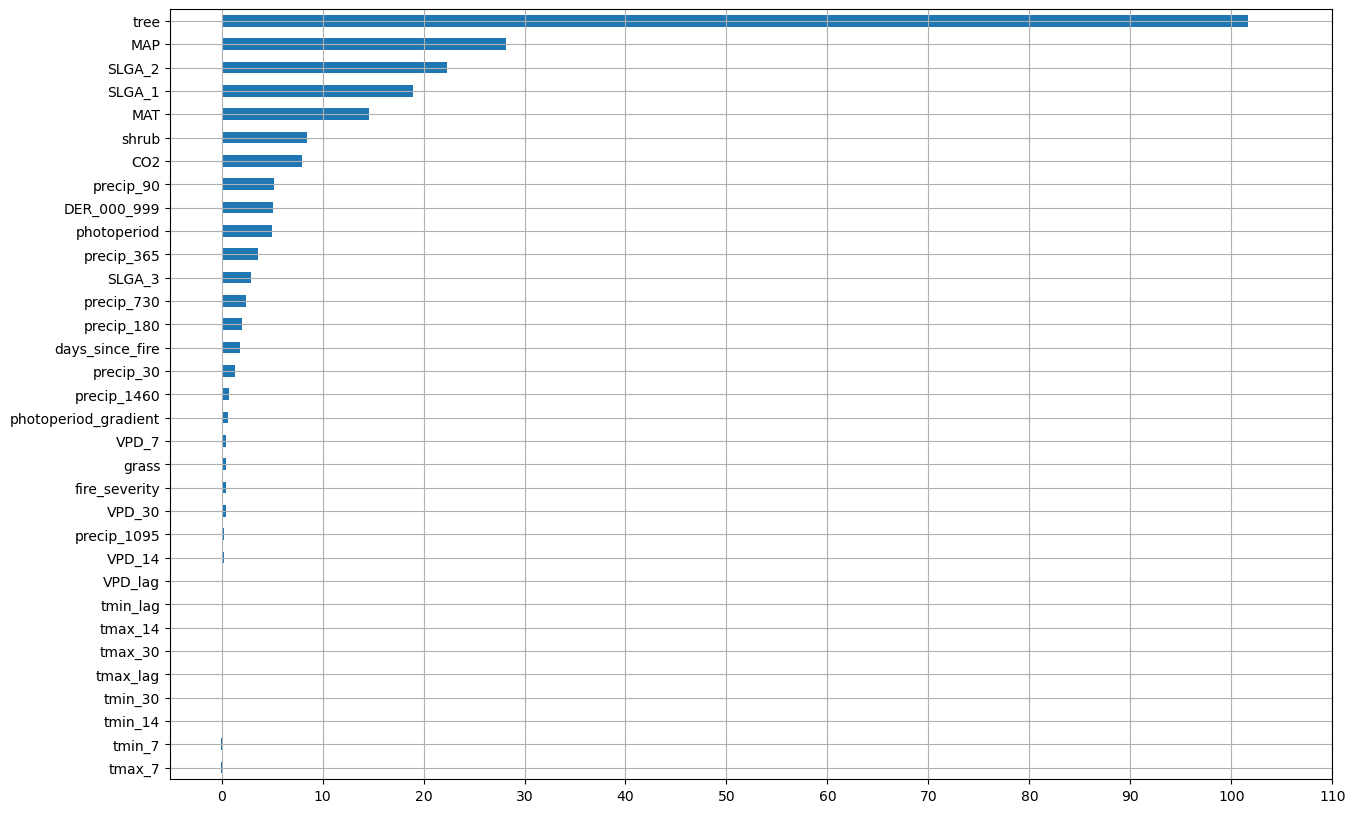

In [60]:
fig, ax = plt.subplots(1)

perm_importance_df_2['importances_mean'].plot.barh(figsize = (15, 10), ax = ax)
xticks = [i for i in range(0, round(max(perm_importance_df_2['importances_mean']) + 10), 10)]
ax.set_xticks(xticks)
plt.grid(True)
plt.xlabel('Mean Gain in MSE')

Text(0.5, 0, 'Mean Gain in MSE')

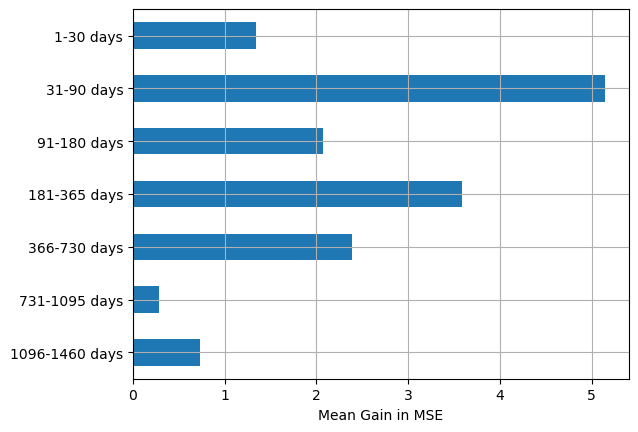

In [66]:
fig, ax = plt.subplots(1)

t = perm_importance_df_2.loc[precip_var]
t['precip_var_set'] = precip_var_set
t = t.set_index('precip_var_set')
t.index.name = None
t['importances_mean'].plot.barh(ax = ax)
plt.grid(True)
plt.xlabel('Mean Gain in MSE')

In [64]:
t.sort_values('importances_mean', ascending = True)

,importances_mean,importances_std
731-1095 days,0.289692,0.064508
1096-1460 days,0.731507,0.077239
1-30 days,1.340036,0.092382
91-180 days,2.070671,0.121813
366-730 days,2.389654,0.145057
181-365 days,3.581902,0.222740
31-90 days,5.148168,0.232667


In [11]:
rf_ale = ALE(reg.predict, feature_names=FEATURES, target_names=TARGET)
rf_exp_tree = rf_ale.explain(np.array(training_merged[FEATURES]))
plot_ale(rf_exp_tree, n_cols=6, fig_kw={'figwidth':15, 'figheight': 30});

directory_plot_output = f"{results_dir}/Plots/ALE_Plots.png"
plt.savefig(fname = directory_plot_output)
plt.close()

doc.add_heading(f'ALE Importance', level=1)
doc.add_picture(directory_plot_output, width=Inches(7))  
doc.add_page_break() 

doc.save(f'{results_dir}/Random_Forest_{selected_super_group}_Results.docx')

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fit

In [27]:
nrow = 7
ncol = 5
fig, ax = plt.subplots(nrow, ncol, figsize = (15,20), sharey = True)

# Iterate through row, then cols

counter = 0
for row in range(nrow):
    for col in range(ncol):
        # Break the loop when the number of features is limited 
        if counter == len(FEATURES):
            break
        f = FEATURES[counter]
        
        ax[row, col].plot(rf_exp_tree['data']['feature_values'][FEATURES.index(f)], 
                rf_exp_tree['data']['ale_values'][FEATURES.index(f)][:, 0], 
                color = 'green', label = 'PV', marker='o', linewidth= 0.5, markersize= 1.5)
        ax[row, col].plot(rf_exp_tree['data']['feature_values'][FEATURES.index(f)], 
                   rf_exp_tree['data']['ale_values'][FEATURES.index(f)][:, 1],
                color = 'blue', label = 'NPV', marker='o', linewidth= 0.5, markersize= 1.5)
        ax[row, col].plot(rf_exp_tree['data']['feature_values'][FEATURES.index(f)], 
                   rf_exp_tree['data']['ale_values'][FEATURES.index(f)][:, 2],
                color = 'brown', label = 'BS', marker='o', linewidth= 0.5, markersize= 1.5)
        ax[row, col].axhline(y=0, color='black', linestyle='--')
        ax[row, col].grid(True)
        ax[row, col].set_xlabel(f)
        
        if col == 0:
            ax[row, col].set_ylabel('ALE')
        counter += 1
plt.tight_layout()

directory_plot_output = f"{results_dir}/Plots/ALE_Plots.png"
plt.savefig(fname = directory_plot_output)
plt.close()

doc.add_heading(f'ALE Importance', level=1)
doc.add_picture(directory_plot_output, width=Inches(7))  
doc.add_page_break() 

doc.save(f'{results_dir}/Random_Forest_{selected_super_group}_Results.docx')


The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a fu

33

In [26]:
rf_exp_tree

Explanation(meta={
  'name': 'ALE',
  'type': ['blackbox'],
  'explanations': ['global'],
  'params': {
              'check_feature_resolution': True,
              'low_resolution_threshold': 10,
              'extrapolate_constant': True,
              'extrapolate_constant_perc': 10.0,
              'extrapolate_constant_min': 0.1,
              'min_bin_points': 4}
            ,
  'version': '0.9.6'}
, data={
  'ale_values': [array([[ 8.03640054, -1.43229359, -6.56321038],
       [ 8.01509534, -1.44150289, -6.53249334],
       [ 8.01661407, -1.399666  , -6.57674985],
       ...,
       [-0.70700619,  0.02781427,  0.6480585 ],
       [-0.70686746,  0.0330007 ,  0.64259205],
       [-0.69306881,  0.04582047,  0.61613111]]), array([[ 4.3854063 , -2.67082574, -1.72120457],
       [ 4.38286228, -2.6655751 , -1.7237129 ],
       [ 4.37873233, -2.67934393, -1.70612448],
       ...,
       [ 0.6593417 , -1.96719814,  1.32182738],
       [ 0.59963912, -1.9309743 ,  1.34662996],
       [ 0.